In [3]:
# Place all code in this notebook

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
bankdata = pd.read_csv("./bank-full.csv", sep=';')
bankdata = bankdata.drop(columns=['duration', 'previous'])
#pd.plotting.scatter_matrix(bankdata, figsize=(20,20))
#plt.show()
bankdata

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,unknown,no


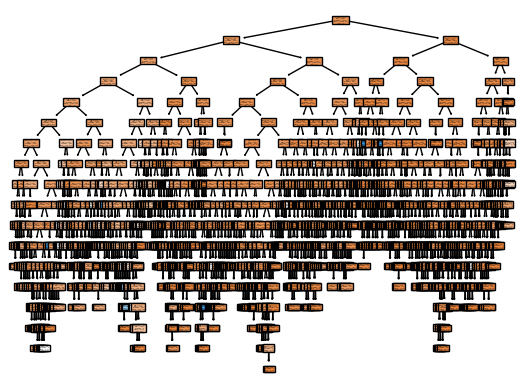

In [5]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Label Encoding for categorical variables
labelencoder = LabelEncoder()
bankdata['job'] = labelencoder.fit_transform(bankdata['job'])
bankdata['marital'] = labelencoder.fit_transform(bankdata['marital'])
bankdata['education'] = labelencoder.fit_transform(bankdata['education'])
bankdata['default'] = labelencoder.fit_transform(bankdata['default'])
bankdata['housing'] = labelencoder.fit_transform(bankdata['housing'])
bankdata['loan'] = labelencoder.fit_transform(bankdata['loan'])
bankdata['contact'] = labelencoder.fit_transform(bankdata['contact'])

bankdata['y'] = labelencoder.fit_transform(bankdata['y'])

# Split the data
X = bankdata[['job', 'marital', 'education','default','housing','loan','contact']]
y = bankdata['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create Decision Tree classifer object
# clf = DecisionTreeClassifier(max_depth=3) for a simpler more direct decision tree
clf = DecisionTreeClassifier() # extremely compelex and unreadable, most data to analyze for where to start with feature importance

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Visualize the tree
plot_tree(clf, feature_names=X.columns.tolist(), class_names=['No', 'Yes'], filled=True)
plt.show()

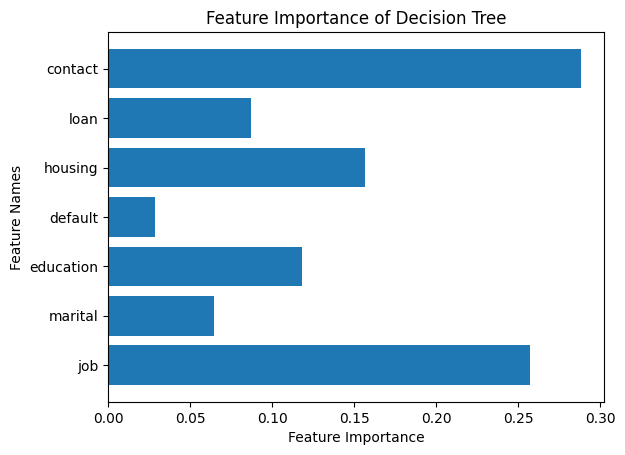

In [6]:
import matplotlib.pyplot as plt
# Shows importance of decision tree features, most useful when decision tree is broadest (no classifier argument)
feature_importance = clf.feature_importances_
feature_names = X.columns.tolist()

plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance of Decision Tree')
plt.show()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.88
Precision: 0.21
Recall: 0.01
F1 Score: 0.02


In [8]:
!pip install fancyimpute # Must label encode when using fancyimpute, KNN also uses the mode instead of the mean from this module

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.7 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29880 sha256=60e78aed2493a3db0b677f46d36af5fe77e1dc1ed2351e31e36920da69e80d37
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=a1ae3538c0d73783b27f0322af1afbcf9ce1d4e6ff5c6506a60a5fe9b256c1af
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN
import pandas as pd
import numpy as np

class CategoricalKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, include_numeric=False, include_cols = []):
        self.encoders = {}
        self.knn_imputer = KNN()
        self.include_numeric = include_numeric
        self.include_cols = include_cols

    def fit(self, X, y=None):
        X = X.copy()

        if self.include_numeric:
            self.cols = X.columns.tolist()
        else:
            self.cols = X.select_dtypes(include=['object', 'category']).columns.tolist()+self.include_cols

        for col in self.cols:
            le = LabelEncoder()
            not_null_mask = X[col].notnull()
            if not_null_mask.sum() > 0:  # Only if there are non-null values to fit
                X.loc[not_null_mask, col] = le.fit_transform(X.loc[not_null_mask, col].astype(str))
                self.encoders[col] = le
        return self

    def transform(self, X):
        X_original = X.copy()
        X = X.copy()

        for col in self.cols:
            if col in self.encoders:  # Only if encoder exists
                not_null_mask = X[col].notnull()
                X.loc[not_null_mask, col] = self.encoders[col].transform(X.loc[not_null_mask, col].astype(str))

        X_imputed = self.knn_imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

        for col in self.cols:
            if col in self.encoders:  # Only if encoder exists
                X_imputed.loc[:, col] = np.round(X_imputed.loc[:, col])  # Rounding only categorical columns
                X_imputed[col] = X_imputed[col].astype(int)  # Converting to int before decoding
                X_imputed[col] = self.encoders[col].inverse_transform(X_imputed[col])

        if not self.include_numeric:
            replacements = [x for x in X.columns if x not in self.cols]
            #numeric_cols = X_original.select_dtypes(include=[np.number]).columns
            X_imputed[replacements] = X_original[replacements]

        return X_imputed

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

bankdata = pd.read_csv("./bank-full.csv", sep=';')
bankdata = bankdata.drop(columns=['duration', 'previous'])

# Impute data
cat_imp = CategoricalKNNImputer()
bankdata_imp = cat_imp.fit_transform(bankdata)

# Label Encoding for categorical variables
labelencoder = LabelEncoder()
bankdata['job'] = labelencoder.fit_transform(bankdata['job'])
bankdata['marital'] = labelencoder.fit_transform(bankdata['marital'])
bankdata['education'] = labelencoder.fit_transform(bankdata['education'])
bankdata['default'] = labelencoder.fit_transform(bankdata['default'])
bankdata['housing'] = labelencoder.fit_transform(bankdata['housing'])
bankdata['loan'] = labelencoder.fit_transform(bankdata['loan'])
bankdata['contact'] = labelencoder.fit_transform(bankdata['contact'])
bankdata['y'] = labelencoder.fit_transform(bankdata['y'])

# Return data into a df, get column labels, and round family history and smoker values
bankdata_imp = pd.DataFrame(bankdata_imp,columns = cat_imp.get_feature_names_out())

# Split the data
X = bankdata[['job', 'marital', 'education','default','housing','loan','contact']]
y = bankdata['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=5) # for a simpler more direct decision tree
# clf = DecisionTreeClassifier() # extremely compelex and unreadable, most data to analyze for where to start with feature importance

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

NameError: ignored